<a href="https://colab.research.google.com/github/wsamuelw/regression-using-tensorflow/blob/main/regression_using_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# predict MPG with neural networks using tensorflow 

# import lib required
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers


In [ ]:
# import the data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

# the data does not contain a header
# so, we need to assign some column names
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]

df = pd.read_csv(url, names = column_names, sep = " ", comment = "\t", na_values = "?", skipinitialspace = True)


In [ ]:
# take a look at the data
df.head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
# create a copy for backup
dataset = df.copy()

# glimpse the data
dataset.describe()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
# check for missing values
# Horsepower has 6 missing values 
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
# use the mean to impute the missing values in Horsepower
dataset['Horsepower'].fillna(dataset['Horsepower'].mean(), inplace = True)

# check for missing values again
# all good! everything is zero
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
# count Origin
# Origin should not be numeric but categorical
dataset['Origin'].value_counts()


1    249
3     79
2     70
Name: Origin, dtype: int64

In [ ]:
# map Origin to a country
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [ ]:
# create dummy variables using Origin
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix = '', prefix_sep = '')
dataset.head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [ ]:
# split the data and create train and test sets
train_dataset = dataset.sample(frac = 0.8, random_state = 884)
test_dataset = dataset.drop(train_dataset.index)


In [ ]:
test_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,0,0,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,0,0,1
12,15.0,8,400.0,150.0,3761.0,9.5,70,0,0,1
15,22.0,6,198.0,95.0,2833.0,15.5,70,0,0,1


In [ ]:
# separate features and labels
# drop MPG from both train and test sets
train_features = train_dataset.drop(["MPG"], axis = 1)
test_features = test_dataset.drop(["MPG"], axis = 1)

# create a label for each set
train_labels = train_dataset["MPG"]
test_labels = test_dataset["MPG"]


In [ ]:
# glimpse the train set
train_dataset.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
MPG,318.0,23.562264,7.943318,9.0,17.00,23.00,29.00,44.6
Cylinders,318.0,5.437107,1.720394,3.0,4.00,4.00,8.00,8.0
Displacement,318.0,192.743711,104.831356,68.0,101.75,140.50,292.00,455.0
Horsepower,318.0,104.768579,38.002815,46.0,75.25,95.00,125.00,225.0
Weight,318.0,2971.440252,850.636048,1613.0,2223.75,2792.00,3600.25,5140.0
Acceleration,318.0,15.541509,2.768338,8.0,13.80,15.45,17.00,24.8
Model Year,318.0,76.034591,3.690990,70.0,73.00,76.00,79.00,82.0
Europe,318.0,0.191824,0.394356,0.0,0.00,0.00,0.00,1.0
Japan,318.0,0.198113,0.399206,0.0,0.00,0.00,0.00,1.0
USA,318.0,0.610063,0.488504,0.0,0.00,1.00,1.00,1.0


In [ ]:
# apply normalization using sklearn
# scale the data such that the mean will be 0 and the standard deviation will be 1
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
label_scaler = StandardScaler()

# fit on training Data
feature_scaler.fit(train_features.values)
label_scaler.fit(train_labels.values.reshape(-1, 1))

# transform both training and testing data
train_features = feature_scaler.transform(train_features.values)
test_features = feature_scaler.transform(test_features.values)

train_labels = label_scaler.transform(train_labels.values.reshape(-1, 1))
test_labels = label_scaler.transform(test_labels.values.reshape(-1, 1))


In [ ]:
# head of the normalised features
train_features[:5]

array([[ 1.49206101,  1.5024525 ,  1.85097102,  1.32881555, -0.91951005,
        -0.82345768, -0.48718999, -0.49705012,  0.79948437],
       [ 0.3277042 ,  0.3081819 , -0.25745395,  0.34447263,  0.16588043,
        -0.2807436 , -0.48718999, -0.49705012,  0.79948437],
       [ 1.49206101,  1.81773994,  1.98274758,  2.33552991, -1.46220529,
        -1.36617175, -0.48718999, -0.49705012,  0.79948437],
       [-0.83665262, -0.6950054 , -0.20474333, -0.56804623, -0.1959164 ,
        -0.55210064, -0.48718999,  2.01186954, -1.25080619],
       [-0.83665262, -0.5039221 , -0.38923051, -0.66341917,  1.43216933,
        -1.09481471, -0.48718999, -0.49705012,  0.79948437]])

In [ ]:
# create a Deep Neural Network to train a regression model
model = Sequential([
    # 2 dense layers specified using Rectified Linear Unit activation function i.e. relu                    
    layers.Dense(32, activation='relu'), # hidden layer with 32 nodes
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # add a dense layer with 1 neuron (output layer with one node)
])


In [ ]:
# define optimizer and loss function
model.compile(optimizer = "RMSProp", loss = "mse")


In [ ]:
# train the model
history = model.fit(epochs = 100, x = train_features, y = train_labels,
          validation_data = (test_features, test_labels), 
          verbose = 0) # disable log for every epoch


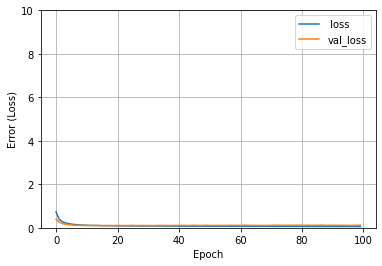

In [ ]:
# def fucntion to plot loss
def plot_loss(history):
    plt.plot(history.history['loss'], label =' loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Error (Loss)')
    plt.legend()
    plt.grid(True)

plot_loss(history)


In [ ]:
# evaluate on testing dataset
model.evaluate(test_features, test_labels)


3/3 [==============================] - 0s 6ms/step - loss: 0.1169


0.11694822460412979

In [ ]:
# make predictions
results = model.predict(test_features)

# decode using the scikit-learn object to get the result
decoded_result = label_scaler.inverse_transform(results.reshape(-1,1))


In [ ]:
decoded_result[:5]

array([[16.357353 ],
       [12.860403 ],
       [11.9914875],
       [15.372311 ],
       [18.906044 ]], dtype=float32)

In [ ]:
# convert array to dataframe
predictions = pd.DataFrame(decoded_result)


In [ ]:
predictions.head()

,0
0,16.357353
1,12.860403
2,11.991488
3,15.372311
4,18.906044


In [ ]:
predictions = predictions.rename(columns={0: 'pred'})


In [ ]:
predictions.head()

,pred
0,16.357353
1,12.860403
2,11.991488
3,15.372311
4,18.906044


In [ ]:
# reset the index
test_dataset.reset_index(drop=True, inplace=True)

# concat 2 datasets
final = pd.concat([test_dataset, predictions], axis=1)


In [ ]:
final

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA,pred
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1,16.357353
1,15.0,8,429.0,198.0,4341.0,10.0,70,0,0,1,12.860403
2,14.0,8,455.0,225.0,4425.0,10.0,70,0,0,1,11.991488
3,15.0,8,400.0,150.0,3761.0,9.5,70,0,0,1,15.372311
4,22.0,6,198.0,95.0,2833.0,15.5,70,0,0,1,18.906044
...,...,...,...,...,...,...,...,...,...,...,...
75,36.0,4,107.0,75.0,2205.0,14.5,82,0,1,0,36.401619
76,32.0,4,91.0,67.0,1965.0,15.7,82,0,1,0,38.238644
77,38.0,4,91.0,67.0,1995.0,16.2,82,0,1,0,37.856857
78,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1,27.185871
